# Amazon Review Sentiment Analysis and modelling Using Biderectional LSTM

# Install and Import Necessary Libray For NLP and Sentiment Analysis

In [5]:
%%capture
!pip install stopwords
!pip install nltk

In [6]:
import pandas as pd
import numpy as np
# import flair
# from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
pd.options.display.max_rows = None

# Import Amazon Product Reviews Dataset and Basic Cleaning

In [7]:
p = 0.3
df = pd.read_csv('../input/amazon-product-reviews/Reviews.csv',skiprows=lambda i: i>0 and rn.random() > p)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
2,14,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,1288915200,fresh and greasy!,good flavor! these came securely packed... the...
3,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...
4,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...


In [8]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName                3
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   10
Text                       0
dtype: int64

In [9]:
df.dropna(axis=0,inplace=True)

In [10]:
df.isnull().sum().sum()

0

In [11]:
df.shape

(170581, 10)

### We can see the ammount of scoring of each review

In [12]:
df.Score.value_counts()

5    108769
4     24164
1     15827
3     12881
2      8940
Name: Score, dtype: int64

In [13]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0

In [14]:
df['Score_New']=df['Score'].apply(score_round)


In [15]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score_New
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
1,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,1
2,14,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,1288915200,fresh and greasy!,good flavor! these came securely packed... the...,1
3,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,1
4,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,0


In [16]:
df.Score_New.value_counts()

1    145814
0     24767
Name: Score_New, dtype: int64

In [17]:
review=df.copy()

In [18]:
review.shape

(170581, 11)

In [19]:
review['number_of_Text_words'] = review['Text'].str.lower().str.split().apply(len)
review['number_of_Summary_words'] = review['Summary'].str.lower().str.split().apply(len)
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score_New,number_of_Text_words,number_of_Summary_words
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,2
1,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,1,25,3
2,14,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,1288915200,fresh and greasy!,good flavor! these came securely packed... the...,1,15,3
3,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,1,24,7
4,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,0,42,2


In [20]:
review_vis = review.copy()
review_vis['Score_New'] = review_vis['Score_New'].replace({0 : 'negative'})
review_vis['Score_New'] = review_vis['Score_New'].replace({1 : 'positive'})


# Data Cleaning for Sentiment Processing

In [21]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### We make a function to clean some basic characters

In [22]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [23]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### We make a function to clean and remove emoji (if there is some)

In [24]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make a function to clean unnecessary whitespaces

In [25]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make a function to clean and remove symbols

In [26]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string  

### We make a function to remove punctuation

In [27]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [28]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)


In [29]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### Then we combine all cleaning functions

In [30]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].map(Stemming)

In [31]:
cleaning(review,'Text')
cleaning(review,'Summary')

In [32]:
review[['Text','Summary']].head()

,Text,Summary
0,look secret ingredi robitussin believ found go...,cough medicin
1,healthi dog food good digest also good small p...,healthi dog food
2,good flavor came secur pack fresh delici love ...,fresh greasi
3,daughter love twizzler shipment six pound real...,lot twizzler expect
4,love eat good watch tv look movi sweet like tr...,poor tast


# 5. Text Tokenizing and Modelling

In [33]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 5.1. Split our data to train and test data

In [34]:
# random split train and test 
index = df.index
review['random_number'] = np.random.randn(len(index))
train = review[review['random_number'] <= 0.8]
test = review[review['random_number'] > 0.8]


In [35]:
train.shape

(134312, 14)

In [36]:
test.shape

(36269, 14)

In [37]:
max_length=100
vocab_size=13000
embedding_dim=64
trunc_type="post"
oov_tok="<OOV>"
padding_type="post"


In [38]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train['Text'])

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train['Text'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, 
                                truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test['Text'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, 
                               truncating=trunc_type)

In [39]:
training_padded[1]

array([   6,    5,  226, 2492,   86,  115,   92,    8, 3660,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [40]:
print(training_sequences[0])

[49, 1856, 78, 12625, 383, 59, 85, 368, 1123, 1152, 759, 25, 6, 63, 590, 465, 5, 1134]


## Bidirectional LSTM Modelling

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM,GRU
from keras.preprocessing import sequence
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score    
from tensorflow.python.keras import models, layers, optimizers   
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers.wrappers import Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(256, dropout=0.3)))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           832000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               657408    
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,489,921
Trainable params: 1,489,921
Non-trainable params: 0
_________________________________________________________________


### Using Adam as optimizer

In [43]:
adam=Adam(learning_rate=0.0001)

In [44]:
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'] )

### Model Training

In [45]:
history=model.fit(training_padded,train['Score_New'], epochs=12, batch_size=256,
                  verbose = 1,callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)],
                  validation_data=(testing_padded,test['Score_New']))

Epoch 1/12
525/525 [==============================] - 450s 845ms/step - loss: 0.3772 - accuracy: 0.8589 - val_loss: 0.2789 - val_accuracy: 0.8843
Epoch 2/12
525/525 [==============================] - 445s 847ms/step - loss: 0.2460 - accuracy: 0.8989 - val_loss: 0.2377 - val_accuracy: 0.9056
Epoch 3/12
525/525 [==============================] - 444s 845ms/step - loss: 0.2216 - accuracy: 0.9098 - val_loss: 0.2259 - val_accuracy: 0.9108
Epoch 4/12
525/525 [==============================] - 446s 850ms/step - loss: 0.2115 - accuracy: 0.9159 - val_loss: 0.2206 - val_accuracy: 0.9111
Epoch 5/12
525/525 [==============================] - 444s 845ms/step - loss: 0.2033 - accuracy: 0.9197 - val_loss: 0.2202 - val_accuracy: 0.9135
Epoch 6/12
525/525 [==============================] - 443s 845ms/step - loss: 0.1966 - accuracy: 0.9223 - val_loss: 0.2246 - val_accuracy: 0.9135
Epoch 7/12
525/525 [==============================] - 444s 846ms/step - loss: 0.1917 - accuracy: 0.9243 - val_loss: 0.2191 -

## Model's Performance Evaluation

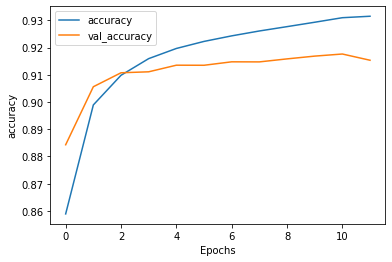

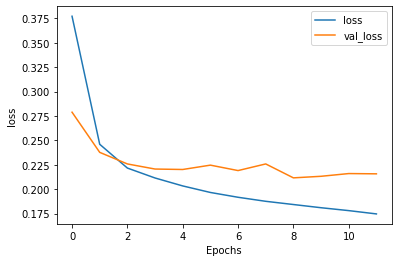

In [46]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [47]:
def Review(sentence):
   sequences = tokenizer.texts_to_sequences(sentence)
   padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

   prob=model.predict(padded)
   if prob>=0.8:
     print(5)
   elif prob>=0.6:
     print(4)
   elif prob>=0.4:
     print(3) 
   elif prob>=0.2:
     print(2)   
   else:
       print(1)

In [48]:
sentence=['Good Product and it fits me']
Review(sentence)

5


In [49]:
sentence=['this is worst thing ever']
Review(sentence)


1


In [50]:
# Predicting the Test set results
y_pred = model.predict(testing_padded)
y_pred = (y_pred > 0.5)
X_test=testing_padded
y_test=test['Score_New']

In [51]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
 
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.915355
Precision: 0.943832
Recall: 0.958069
F1 score: 0.950897
ROC AUC: 0.810301
[[ 3473  1769]
 [ 1301 29726]]


In [53]:
#Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      5242
           1       0.94      0.96      0.95     31027

    accuracy                           0.92     36269
   macro avg       0.84      0.81      0.82     36269
weighted avg       0.91      0.92      0.91     36269



<AxesSubplot:>

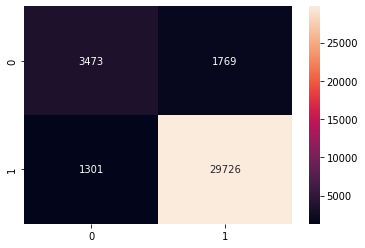

In [54]:
#Confusion Matrix
import seaborn as sns
sns.heatmap(matrix,annot=True,fmt='')

In [58]:
model.save("Review_classification_model.h5")